## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

## Load Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/datasets/cleaned_retail_data.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpending
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


## Create Customer Features by Aggregating the Data

In [4]:
customer_features = df.groupby('CustomerID').agg({
    'Quantity':'sum', # Calculates the total quantity of item purchased by each customer (by summing up the "Quantity vaues for all their transaction)
    'TotalSpending':"sum",
    'InvoiceNo':'nunique', # Calculates the number of unique invoice (Transactions) for each customer.
    'StockCode':'nunique'}).reset_index() # We are going to pass a dictionary

In [5]:
customer_features

,CustomerID,Quantity,TotalSpending,InvoiceNo,StockCode
0,12347.0,1893,3314.73,7,96
1,12348.0,140,90.20,3,6
2,12349.0,523,999.15,1,58
3,12350.0,196,294.40,1,16
4,12352.0,437,1010.61,8,49
...,...,...,...,...,...
4217,18280.0,40,137.00,1,8
4218,18281.0,52,46.92,1,5
4219,18282.0,46,111.68,3,9
4220,18283.0,1353,2002.63,16,259


## Standardize the features

In [6]:
listx = customer_features.columns

In [7]:
listx

Index(['CustomerID', 'Quantity', 'TotalSpending', 'InvoiceNo', 'StockCode'], dtype='object')

In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[listx])

In [9]:
scaled_features

array([[-1.7121745 ,  1.04909326,  1.06536263,  0.28890503,  0.53472205],
       [-1.71159329, -0.36334035, -0.42310367, -0.19541383, -0.64221283],
       [-1.71101209, -0.05474818, -0.00352579, -0.43757326,  0.03779399],
       ...,
       [ 1.73725647, -0.43907837, -0.41318834, -0.19541383, -0.60298167],
       [ 1.73783767,  0.61400247,  0.45968781,  1.37862247,  2.66628188],
       [ 1.74016247,  0.15071136, -0.02124689, -0.19541383, -0.11913066]])

## Perform Hierarchical Clustering

In [11]:
linkage_matrix = linkage(scaled_features,method = 'ward',metric = 'euclidean')

## Plot the dendrogram

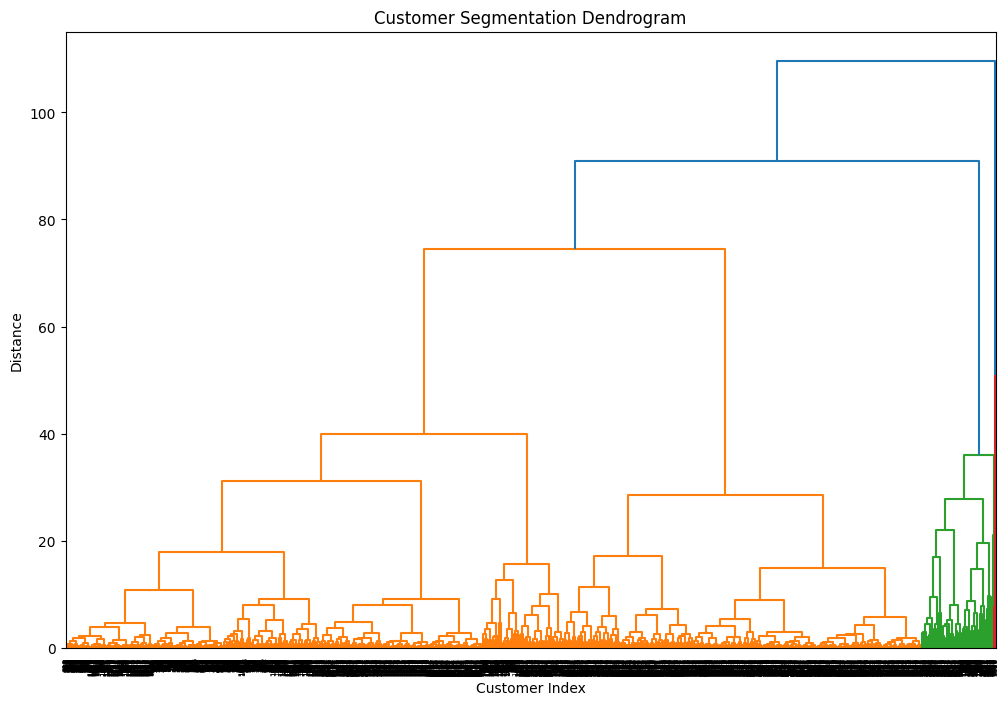

In [12]:
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Customer Segmentation Dendrogram')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()

# `Let's say we choose 4 clusters (this would be determined by examining the dendrogram)`

In [13]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
customer_features['Cluster'] = cluster.fit_predict(scaled_features)

In [14]:
customer_features

,CustomerID,Quantity,TotalSpending,InvoiceNo,StockCode,Cluster
0,12347.0,1893,3314.73,7,96,1
1,12348.0,140,90.20,3,6,1
2,12349.0,523,999.15,1,58,1
3,12350.0,196,294.40,1,16,1
4,12352.0,437,1010.61,8,49,1
...,...,...,...,...,...,...
4217,18280.0,40,137.00,1,8,3
4218,18281.0,52,46.92,1,5,3
4219,18282.0,46,111.68,3,9,3
4220,18283.0,1353,2002.63,16,259,2


In [15]:
# Analyze cluster characteristics
cluster_summary = customer_features.groupby('Cluster').agg({
    'Quantity': ['mean', 'std'],
    'TotalSpending': ['mean', 'std'],
    'InvoiceNo': ['mean', 'std'],
    'StockCode': ['mean', 'std'],
    'CustomerID': 'count'
})

In [16]:
cluster_summary

Quantity               TotalSpending                 InvoiceNo  \
                 mean           std          mean           std        mean   
Cluster                                                                       
0        22356.000000  13172.625494  38644.361667  22733.558255  125.000000   
1          418.213528    454.493672    709.943025    764.530653    3.477454   
2         2581.566667   1436.012908   4458.644576   2744.004895   17.427273   
3          346.634852    329.333009    579.771713    557.340724    3.148399   

                      StockCode             CustomerID  
               std         mean         std      count  
Cluster                                                 
0        87.631045  1073.833333  451.863438          6  
1         3.732210    39.918656   38.756895       2262  
2        13.528396   202.351515  104.483957        330  
3         2.523974    42.585591   39.419244       1624

## Visualize the clusters

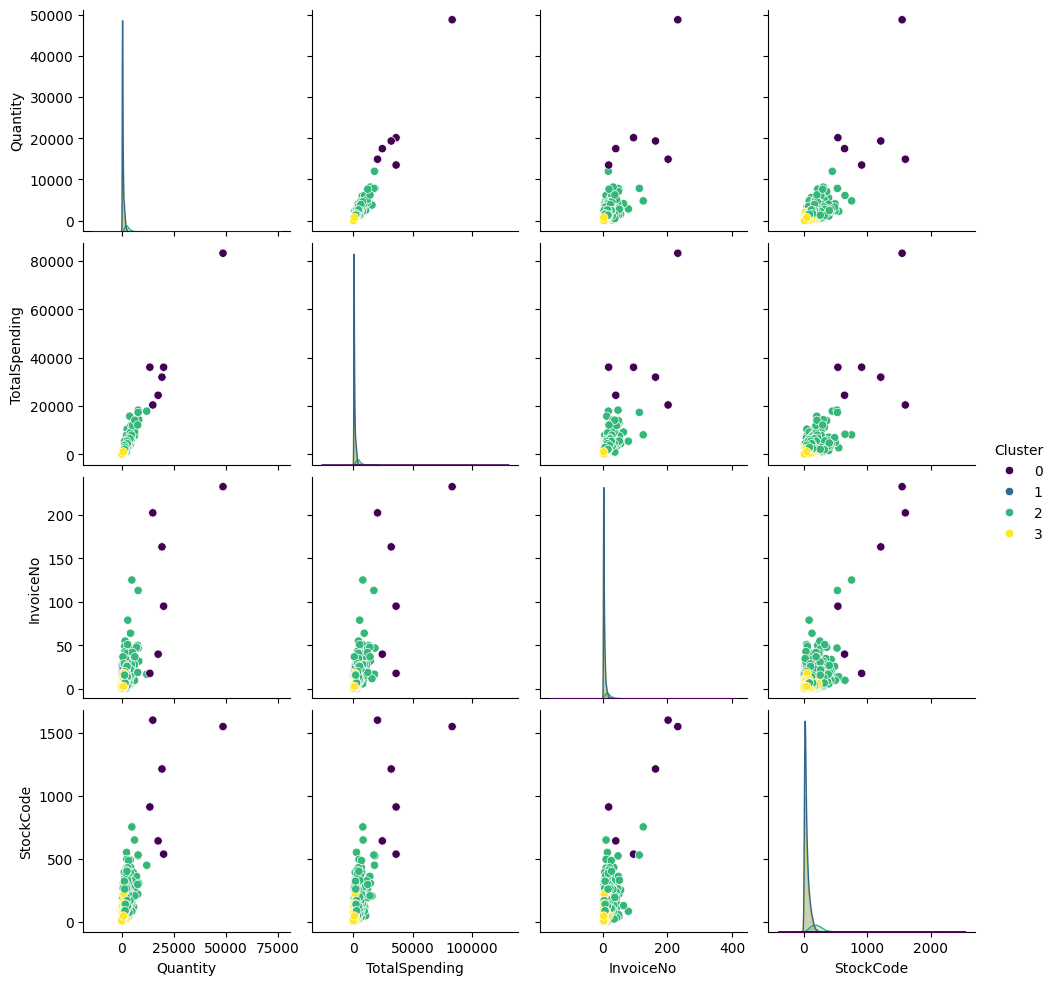

In [17]:
import seaborn as sns

# Pairplot of features colored by cluster
sns.pairplot(customer_features,
             vars=['Quantity', 'TotalSpending', 'InvoiceNo', 'StockCode'],
             hue='Cluster',
             palette='viridis')
plt.show()